In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

# import xgboost as xgb

# Next two only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [2]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

y_test_comp = pd.read_csv('data/test_set_features.csv')

df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [3]:
X['hhs_geo_region'].value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

In [4]:
X['education'].value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [5]:
X['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [6]:
X['marital_status'].value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [7]:
X['rent_or_own'].value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

In [8]:
X['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [9]:
X.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


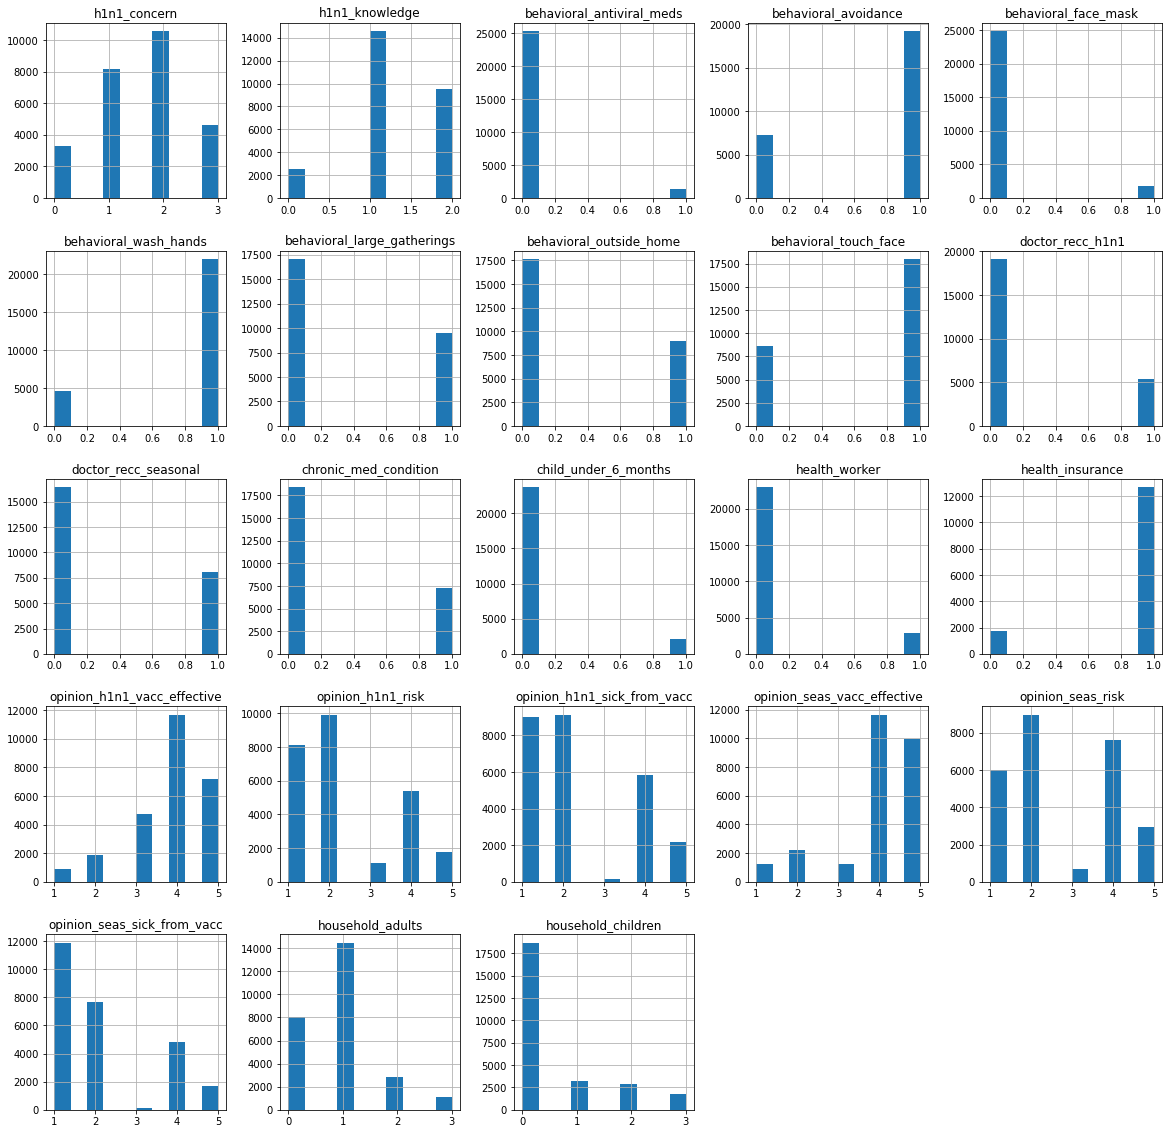

In [10]:
X.hist(figsize=(20,20));

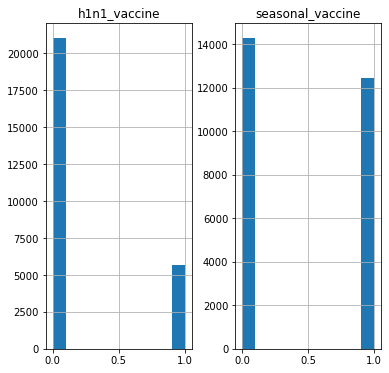

In [11]:
y.hist(figsize=(6,6));

We'll first check to see if the classes are imbalanced.

In [12]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is likely not a problem though, so we won't do anything about it for now.

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [14]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [16]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)
cat_columns = list(X.columns[X.dtypes == 'object'].values)

### Simple Imputer

In [17]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [18]:
X_train_imp.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

### One Hot Encoder

In [19]:
X_train_cat = X_train_imp[cat_columns]
X_test_cat = X_test_imp[cat_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat), columns=ohe.get_feature_names(), index=X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat), columns=ohe.get_feature_names(), index=X_test_cat.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
X_train_ohe.isna().sum()

h1n1_concern                 0
h1n1_knowledge               0
behavioral_antiviral_meds    0
behavioral_avoidance         0
behavioral_face_mask         0
                            ..
x11_vlluhbov                 0
x11_xgwztkwe                 0
x11_xqwwgdyp                 0
x11_xtkaffoo                 0
x11_xzmlyyjv                 0
Length: 105, dtype: int64

### Standard Scaler

In [21]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

Something that we're doing is indroducing NaNs back into the data, perhaps something like dividing by zero. We'll remove those for now, but we'll need to figure out what caused that to avoid it moving forward.

### Fitting a model

In [22]:
log_reg = LogisticRegression()
multi_reg = MultiOutputClassifier(log_reg)

multi_reg.fit(X_train_scaled, y_train);

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


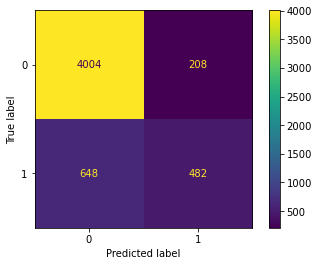

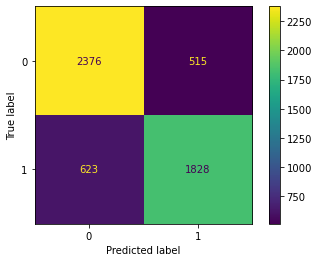

In [23]:
log_reg.fit(X_train_scaled, y_train.iloc[:,0])
plot_confusion_matrix(log_reg, X_test_scaled, y_test.iloc[:,0]);

log_reg.fit(X_train_scaled, y_train.iloc[:,1])
plot_confusion_matrix(log_reg, X_test_scaled, y_test.iloc[:,1]);

In [24]:
y_hat = multi_reg.predict(X_test_scaled)

print(f'Recall for H1N1:            {recall_score(y_test.iloc[:,0], y_hat[:,0])}')
print(f'Recall for seasonal flu:    {recall_score(y_test.iloc[:,1], y_hat[:,1])}\n')
print(f'Precision for H1N1:         {precision_score(y_test.iloc[:,0], y_hat[:,0])}')
print(f'Precision for seasonal flu: {precision_score(y_test.iloc[:,1], y_hat[:,1])}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test.iloc[:,0], y_hat[:,0])}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test.iloc[:,1], y_hat[:,1])}\n')
print(f'F1 score for H1N1:          {f1_score(y_test.iloc[:,0], y_hat[:,0])}')
print(f'F1 score for seasonal flu:  {f1_score(y_test.iloc[:,1], y_hat[:,1])}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test.iloc[:,0], y_hat[:,0])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test.iloc[:,1], y_hat[:,1])}')

Recall for H1N1:            0.4265486725663717
Recall for seasonal flu:    0.7458180334557324

Precision for H1N1:         0.6985507246376812
Precision for seasonal flu: 0.7801963294921042

Accuracy for H1N1:          0.8397603893672781
Accuracy for seasonal flu:  0.7869711718457506

F1 score for H1N1:          0.5296703296703297
F1 score for seasonal flu:  0.7626199415936588

AUROC for H1N1:             0.6885829782584945
AUROC for seasonal flu:     0.7838394906123352


## Hist Gradient Boosting Baseline Model

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]
y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


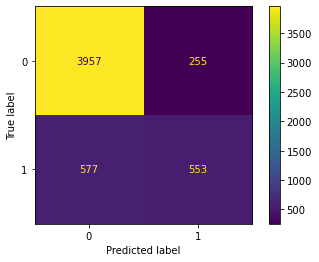

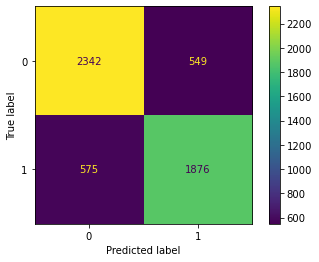

In [42]:
model_baseline_h1n1 = HistGradientBoostingClassifier()
model_baseline_ssnl = HistGradientBoostingClassifier()

model_baseline_h1n1.fit(X_train_scaled, y_train_h1n1)
plot_confusion_matrix(model_baseline_h1n1, X_test_scaled, y_test_h1n1);

model_baseline_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(model_baseline_ssnl, X_test_scaled, y_test_ssnl);


In [43]:
# For scoring

y_hat_h1n1_1 = model_baseline_h1n1.predict(X_test_scaled)
y_hat_ssnl_1 = model_baseline_ssnl.predict(X_test_scaled)
y_proba_h1n1_1 = model_baseline_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_1 = model_baseline_ssnl.predict_proba(X_test_scaled)

In [44]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_1)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_1)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_1)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_1)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_1[:,1])}')

Recall for H1N1:            0.4893805309734513
Recall for seasonal flu:    0.7654018767849857

Precision for H1N1:         0.6844059405940595
Precision for seasonal flu: 0.7736082474226804

Accuracy for H1N1:          0.8442530887308124
Accuracy for seasonal flu:  0.7895919131411456

F1 score for H1N1:          0.5706914344685242
F1 score for seasonal flu:  0.7694831829368335

AUROC for H1N1:             0.8412029683416113
AUROC for seasonal flu:     0.8614359960941828


## Hist Gradient Boosting Model 2

HistGradientBoosting(loss='auto', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)[source]¶

### H1N1 Model

In the succeeding models, we'll use GridSearchCV to search for the best hyperparameters from lists we provide.  This model will use 3 of the most commonly adjusted hyperparameters - max_iter, max_depth and learning_rate.

In [26]:
# Create parameters to iterate

model_2_h1n1 = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

NameError: name 'HistGradientBoostingClassifier' is not defined

In [27]:
# GridSearchCV

cv_h1n1 = GridSearchCV(model_2_h1n1,parameters,cv=5)
cv_h1n1.fit(X_train_scaled, y_train_h1n1.values.ravel())

NameError: name 'model_2_h1n1' is not defined

In [47]:
# Function to print the best parameters

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
#    mean_score = results.cv_results_['mean_test_score']
#    std_score = results.cv_results_['std_test_score']
#    params = results.cv_results_['params']
#    for mean,std,params in zip(mean_score,std_score,params):
#        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [48]:
display(cv_h1n1) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 70}




#### SSNL Model

In [49]:
# Create parameters to iterate

model_2_ssnl = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [50]:
# GridSearchCV

cv_ssnl = GridSearchCV(model_2_ssnl,parameters,cv=5)
cv_ssnl.fit(X_train_scaled, y_train_ssnl.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100]})

In [51]:
display(cv_ssnl) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 70}




### Results

In [52]:
#H1N1 model with parameters from GridSearchCV

model_2_h1n1 = HistGradientBoostingClassifier(max_iter = 70, max_depth = 9, learning_rate = .1)
model_2_h1n1.fit(X_test_scaled, y_test_h1n1)

HistGradientBoostingClassifier(max_depth=9, max_iter=70)

In [53]:
#SSNL model with parameters from GridSearchCV

model_2_ssnl = HistGradientBoostingClassifier(max_iter = 7, max_depth = 5, learning_rate = .1)
model_2_ssnl.fit(X_test_scaled, y_test_ssnl)

HistGradientBoostingClassifier(max_depth=5, max_iter=7)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


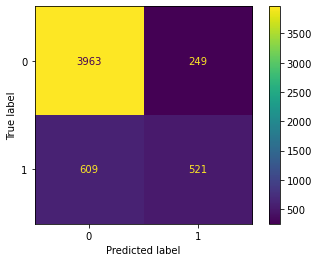

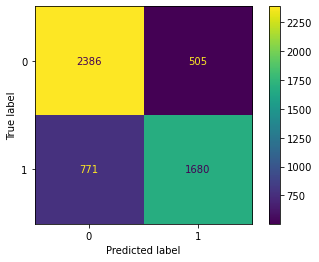

In [54]:
# Confusion Matrices

model_2_h1n1.fit(X_train_scaled, y_train_h1n1)
plot_confusion_matrix(model_2_h1n1, X_test_scaled, y_test_h1n1);

model_2_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(model_2_ssnl, X_test_scaled, y_test_ssnl);

In [55]:
# For scoring

y_hat_h1n1_2 = model_2_h1n1.predict(X_test_scaled)
y_hat_ssnl_2 = model_2_ssnl.predict(X_test_scaled)
y_proba_h1n1_2 = model_2_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_2 = model_2_ssnl.predict_proba(X_test_scaled)

In [56]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_2)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_2)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_2)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_2)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_2)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_2)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1,y_hat_h1n1_2)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_2)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_2[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_2[:,1])}')

Recall for H1N1:            0.46106194690265484
Recall for seasonal flu:    0.6854345165238678

Precision for H1N1:         0.6766233766233766
Precision for seasonal flu: 0.7688787185354691

Accuracy for H1N1:          0.8393859977536503
Accuracy for seasonal flu:  0.7611381505054287

F1 score for H1N1:          0.5484210526315789
F1 score for seasonal flu:  0.7247627264883519

AUROC for H1N1:             0.8407449428098395
AUROC for seasonal flu:     0.840036066290508


## Hist Gradient Boosting Model 3

This model adds "max_leaf_nodes" to the mix without changing other parameters

### H1N1 Model

In [57]:
# Create parameters to iterate

model_3_h1n1 = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100],
    "max_leaf_nodes":[20,25,30,35,40]
}

In [58]:
# GridSearchCV

cv_h1n1 = GridSearchCV(model_3_h1n1,parameters,cv=5)
cv_h1n1.fit(X_train_scaled, y_train_h1n1.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100],
                         'max_leaf_nodes': [20, 25, 30, 35, 40]})

In [59]:
display(cv_h1n1) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 70, 'max_leaf_nodes': 40}




#### SSNL Model

In [60]:
# Create parameters to iterate

model_3_ssnl = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100],
    "max_leaf_nodes":[20,25,30,35,40]
}

In [61]:
# GridSearchCV

cv_ssnl = GridSearchCV(model_3_ssnl,parameters,cv=5)
cv_ssnl.fit(X_train_scaled, y_train_ssnl.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100],
                         'max_leaf_nodes': [20, 25, 30, 35, 40]})

In [62]:
display(cv_ssnl) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 50, 'max_leaf_nodes': 35}




### Results

In [63]:
#H1N1 model with parameters from GridSearchCV

model_3_h1n1 = HistGradientBoostingClassifier(max_iter = 50, max_depth = 5, learning_rate = .1, max_leaf_nodes = 40)
model_3_h1n1.fit(X_test_scaled, y_test_h1n1)

HistGradientBoostingClassifier(max_depth=5, max_iter=50, max_leaf_nodes=40)

In [64]:
#SSNL model with parameters from GridSearchCV

model_3_ssnl = HistGradientBoostingClassifier(max_iter = 70, max_depth = 9, learning_rate = .1, max_leaf_nodes = 20)
model_3_ssnl.fit(X_test_scaled, y_test_ssnl)

HistGradientBoostingClassifier(max_depth=9, max_iter=70, max_leaf_nodes=20)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


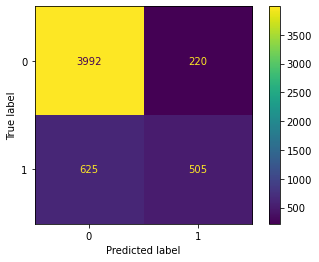

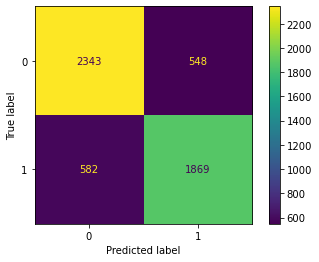

In [65]:
# Confusion Matrices

model_3_h1n1.fit(X_train_scaled, y_train_h1n1)
plot_confusion_matrix(model_3_h1n1, X_test_scaled, y_test_h1n1);

model_3_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(model_3_ssnl, X_test_scaled, y_test_ssnl);

In [66]:
# For scoring

y_hat_h1n1_3 = model_3_h1n1.predict(X_test_scaled)
y_hat_ssnl_3 = model_3_ssnl.predict(X_test_scaled)
y_proba_h1n1_3 = model_3_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_3 = model_3_ssnl.predict_proba(X_test_scaled)

In [67]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_3)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_3)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_3)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_3)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_3)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_3)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_3)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_3)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_3[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_3[:,1])}')

Recall for H1N1:            0.4469026548672566
Recall for seasonal flu:    0.762545899632803

Precision for H1N1:         0.696551724137931
Precision for seasonal flu: 0.7732726520479933

Accuracy for H1N1:          0.8418195432422314
Accuracy for seasonal flu:  0.7884687383002621

F1 score for H1N1:          0.5444743935309972
F1 score for seasonal flu:  0.7678718159408382

AUROC for H1N1:             0.8413952130028824
AUROC for seasonal flu:     0.8611062540071107


## Hist Gradient Boosting Model 4

HistGradientBoosting(loss='auto', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)[source]¶

### H1N1 Model

In [68]:
# Create parameters to iterate

model_4_h1n1 = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,0.25,1.5,2],
    "max_bins":[10, 50, 150, 200, 255]
}

In [69]:
# GridSearchCV

cv_h1n1 = GridSearchCV(model_4_h1n1,parameters,cv=5)
cv_h1n1.fit(X_train_scaled, y_train_h1n1.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25, 1.5, 2],
                         'max_bins': [10, 50, 150, 200, 255],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100]})

In [70]:
display(cv_h1n1) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_bins': 150, 'max_depth': 5, 'max_iter': 50}




#### SSNL Model

In [71]:
# Create parameters to iterate

model_4_ssnl = HistGradientBoostingClassifier()
parameters = {
    "max_iter":[10, 30, 50, 70, 100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,0.25,1.5,2],
    "max_bins":[10, 50, 150, 200, 255]
}

In [72]:
# GridSearchCV

cv_ssnl = GridSearchCV(model_4_ssnl,parameters,cv=5)
cv_ssnl.fit(X_train_scaled, y_train_ssnl.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25, 1.5, 2],
                         'max_bins': [10, 50, 150, 200, 255],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_iter': [10, 30, 50, 70, 100]})

In [73]:
display(cv_ssnl) # best parameters

Best parameters are: {'learning_rate': 0.1, 'max_bins': 50, 'max_depth': 7, 'max_iter': 70}




### Results

In [74]:
#H1N1 model with parameters from GridSearchCV

model_4_h1n1 = HistGradientBoostingClassifier(max_iter = 70, max_depth = 5, learning_rate = .1, max_bins = 150)
model_4_h1n1.fit(X_test_scaled, y_test_h1n1)

HistGradientBoostingClassifier(max_bins=150, max_depth=5, max_iter=70)

In [75]:
#SSNL model with parameters from GridSearchCV

model_4_ssnl = HistGradientBoostingClassifier(max_iter = 100, max_depth = 5, learning_rate = .1, max_bins = 10)
model_4_ssnl.fit(X_test_scaled, y_test_ssnl)

HistGradientBoostingClassifier(max_bins=10, max_depth=5)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


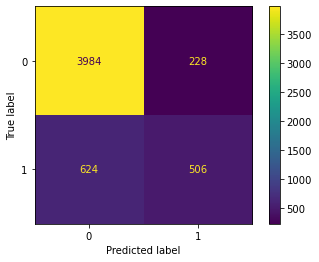

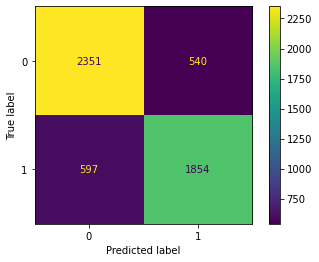

In [76]:
# Confusion Matrices

model_4_h1n1.fit(X_train_scaled, y_train_h1n1)
plot_confusion_matrix(model_4_h1n1, X_test_scaled, y_test_h1n1);

model_4_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(model_4_ssnl, X_test_scaled, y_test_ssnl);

In [77]:
# For scoring

y_hat_h1n1_4 = model_4_h1n1.predict(X_test_scaled)
y_hat_ssnl_4 = model_4_ssnl.predict(X_test_scaled)
y_proba_h1n1_4 = model_4_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_4 = model_4_ssnl.predict_proba(X_test_scaled)

In [78]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_4)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_4)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_4)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_4)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_4)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_4)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_4)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_4)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_4[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_4[:,1])}')

Recall for H1N1:            0.44778761061946903
Recall for seasonal flu:    0.7564259485924113

Precision for H1N1:         0.6893732970027248
Precision for seasonal flu: 0.7744360902255639

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.7871583676525645

F1 score for H1N1:          0.5429184549356224
F1 score for seasonal flu:  0.7653250773993808

AUROC for H1N1:             0.838505870290531
AUROC for seasonal flu:     0.8623603747247505


## Hist Gradient Boosting Model 5

HistGradientBoosting(loss='auto', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)[source]¶

### H1N1 Model

In [79]:
# Create parameters to iterate

model_5_h1n1 = HistGradientBoostingClassifier()
parameters = {
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,0.25,1.5,2]
}

In [80]:
# GridSearchCV

cv_h1n1 = GridSearchCV(model_5_h1n1,parameters,cv=5)
cv_h1n1.fit(X_train_scaled, y_train_h1n1.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25, 1.5, 2],
                         'max_depth': [1, 3, 5, 7, 9]})

In [81]:
display(cv_h1n1) # best parameters

Best parameters are: {'learning_rate': 0.25, 'max_depth': 3}




#### SSNL Model

In [82]:
# Create parameters to iterate

model_5_ssnl = HistGradientBoostingClassifier()
parameters = {
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,0.25,1.5,2]
}

In [83]:
# GridSearchCV

cv_ssnl = GridSearchCV(model_5_ssnl,parameters,cv=5)
cv_ssnl.fit(X_train_scaled, y_train_ssnl.values.ravel())

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.25, 1.5, 2],
                         'max_depth': [1, 3, 5, 7, 9]})

In [84]:
display(cv_ssnl) # best parameters

Best parameters are: {'learning_rate': 0.25, 'max_depth': 3}




### Results

In [85]:
#H1N1 model with parameters from GridSearchCV

model_5_h1n1 = HistGradientBoostingClassifier(max_depth = 3, learning_rate = .25)
model_5_h1n1.fit(X_test_scaled, y_test_h1n1)

HistGradientBoostingClassifier(learning_rate=0.25, max_depth=3)

In [86]:
#SSNL model with parameters from GridSearchCV

model_5_ssnl = HistGradientBoostingClassifier(max_depth = 9, learning_rate = .1)
model_5_ssnl.fit(X_test_scaled, y_test_ssnl)

HistGradientBoostingClassifier(max_depth=9)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


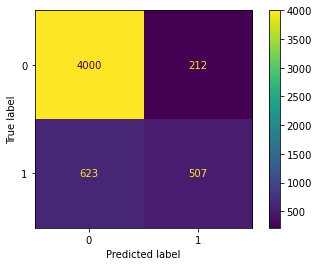

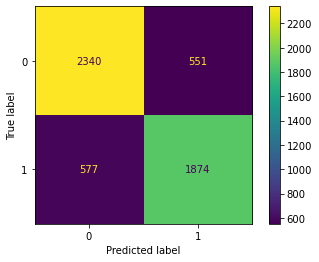

In [87]:
# Confusion Matrices

model_5_h1n1.fit(X_train_scaled, y_train_h1n1)
plot_confusion_matrix(model_5_h1n1, X_test_scaled, y_test_h1n1);

model_5_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(model_5_ssnl, X_test_scaled, y_test_ssnl);

In [88]:
# For scoring

y_hat_h1n1_5 = model_5_h1n1.predict(X_test_scaled)
y_hat_ssnl_5 = model_5_ssnl.predict(X_test_scaled)
y_proba_h1n1_5 = model_5_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_5 = model_5_ssnl.predict_proba(X_test_scaled)

In [89]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_5)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_5)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_5)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_5)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_5)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_5)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_5)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_5)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_5[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_5[:,1])}')

Recall for H1N1:            0.4486725663716814
Recall for seasonal flu:    0.7645858833129335

Precision for H1N1:         0.7051460361613352
Precision for seasonal flu: 0.7727835051546392

Accuracy for H1N1:          0.8436915013103706
Accuracy for seasonal flu:  0.7888431299138899

F1 score for H1N1:          0.5484045429962142
F1 score for seasonal flu:  0.7686628383921247

AUROC for H1N1:             0.8381962828496753
AUROC for seasonal flu:     0.8615417704122912


## Function to return metrics

In [90]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False):
    """
    This function takes in y_data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    Note: save_fig is only supported for single models.
    
    """
    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in range(len(y_actuals)):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    model_scoring_dict[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax1.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                print(f'Scores for {model_name}:')
            else:
                all_scores['model'] = model_scores
                print(f'Scores for this model:')
            
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

In [91]:
# all_metrics(y_test_h1n1, y_hat_h1n1, y_proba_h1n1, model_name='jack')

In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### SVM Model

#### H1N1 Model

In [40]:
svm_1_h1n1 = SVC(kernel='linear', probability = True)
svm_1_h1n1.fit(X_train_scaled, y_train_h1n1)

SVC(kernel='linear', probability=True)

In [94]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train_scaled, y_train_h1n1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.788 total time= 1.3min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.787 total time= 1.3min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.787 total time= 1.2min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.787 total time= 1.3min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.787 total time= 1.3min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.788 total time= 1.0min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=  58.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=  55.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=  56.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.787 total time=  56.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.818 total time=  15.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [95]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [96]:
grid_predictions = grid.predict(X_test_scaled)
 
# print classification report
print(classification_report(y_test_h1n1, grid_predictions))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4212
           1       0.69      0.44      0.54      1130

    accuracy                           0.84      5342
   macro avg       0.78      0.69      0.72      5342
weighted avg       0.83      0.84      0.83      5342



#### SSNL Model

In [97]:
svm_1_ssnl = SVC(kernel='linear', probability = True)
svm_1_ssnl.fit(X_train_scaled,y_train_ssnl)

SVC(kernel='linear', probability=True)

In [98]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train_scaled, y_train_ssnl)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=  56.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=  55.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=  55.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=  55.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=  55.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.533 total time= 1.0min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.533 total time= 1.0min
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.533 total time= 1.0min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.533 total time= 1.0min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.533 total time= 1.0min
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.763 total time=  24.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [99]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


In [100]:
grid_predictions = grid.predict(X_test_scaled)
 
# print classification report
print(classification_report(y_test_h1n1, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74      4212
           1       0.33      0.69      0.45      1130

    accuracy                           0.65      5342
   macro avg       0.61      0.66      0.59      5342
weighted avg       0.77      0.65      0.68      5342



### Scoring

In [101]:
# For scoring

y_hat_h1n1_svm_1 = svm_1_h1n1.predict(X_test_scaled)
y_hat_ssnl_svm_1 = svm_1_ssnl.predict(X_test_scaled)
y_proba_h1n1_svm_1 = svm_1_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_svm_1 = svm_1_ssnl.predict_proba(X_test_scaled)

In [102]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_svm_1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_svm_1[:,1])}')

Recall for H1N1:            0.4353982300884956
Recall for seasonal flu:    0.7384740922072623

Precision for H1N1:         0.6684782608695652
Precision for seasonal flu: 0.7798362774666092

Accuracy for H1N1:          0.8348932983901161
Accuracy for seasonal flu:  0.7843504305503557

F1 score for H1N1:          0.527331189710611
F1 score for seasonal flu:  0.7585917854149203

AUROC for H1N1:             0.8285122994562523
AUROC for seasonal flu:     0.8562804330495137


In [41]:
svm_1_ssnl = SVC(probability = True, kernel='linear', C=1, gamma=0.001)
svm_1_ssnl.fit(X_test_scaled,y_test_ssnl)

svm_1_h1n1 = SVC(probability = True, kernel='linear', C=1, gamma=0.001)
svm_1_h1n1.fit(X_test_scaled,y_test_h1n1)

SVC(C=1, gamma=0.001, kernel='linear', probability=True)

In [104]:
y_hat_h1n1_svm_1 = svm_1_h1n1.predict(X_test_scaled)
y_hat_ssnl_svm_1 = svm_1_ssnl.predict(X_test_scaled)
y_proba_h1n1_svm_1 = svm_1_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl_svm_1 = svm_1_ssnl.predict_proba(X_test_scaled)

In [105]:
# Print scoring

print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1_svm_1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl_svm_1)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1_svm_1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl_svm_1[:,1])}')

Recall for H1N1:            0.46371681415929206
Recall for seasonal flu:    0.7421460628314973

Precision for H1N1:         0.6831812255541069
Precision for seasonal flu: 0.7857451403887689

Accuracy for H1N1:          0.8410707600149757
Accuracy for seasonal flu:  0.7888431299138899

F1 score for H1N1:          0.5524512387981023
F1 score for seasonal flu:  0.7633235417540915

AUROC for H1N1:             0.8357806183764884
AUROC for seasonal flu:     0.8616409823477551


In [106]:
(8357547756515307 + 8616409823477551) / 2

8486978789996429.0

In [26]:
svm_1_ssnl = SVC(kernel='linear', C=1, gamma=0.001)
svm_1_ssnl.fit(X_train_scaled, y_train_ssnl)

SVC(C=1, gamma=0.001, kernel='linear')

In [27]:
from sklearn.metrics import classification_report
predictions = svm_1_ssnl.predict(X_test_scaled)
print(classification_report(y_test_ssnl, predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2891
           1       0.78      0.74      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


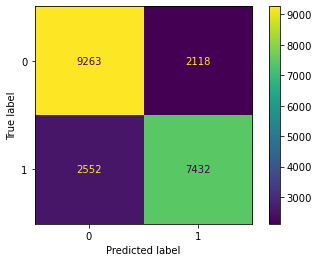

In [28]:
# svm_1_ssnl.fit(X_train_scaled, y_train_ssnl)
plot_confusion_matrix(svm_1_ssnl, X_test_scaled, y_test_ssnl);

In [29]:
import eli5
from eli5.sklearn import PermutationImportance
# svm_1_ssnl = HistGradientBoostingClassifier(learning_rate=0.1, max_depth=9, max_iter=70)
# vm_1_ssnl.fit(X_test_scaled, y_test_ssnl)
perm = PermutationImportance(svm_1_ssnl, random_state=42).fit(X_test_scaled, y_test_ssnl)
eli5.show_weights(perm, feature_names = X_test_scaled.columns.tolist())

Weight,Feature
0.0670 ± 0.0070,opinion_seas_risk
0.0559 ± 0.0072,doctor_recc_seasonal
0.0394 ± 0.0047,opinion_seas_vacc_effective
0.0199 ± 0.0041,x0_65+ Years
0.0072 ± 0.0037,x0_18 - 34 Years
0.0047 ± 0.0039,opinion_seas_sick_from_vacc
0.0038 ± 0.0023,health_worker
0.0022 ± 0.0007,x0_45 - 54 Years
0.0021 ± 0.0043,x0_35 - 44 Years
0.0019 ± 0.0009,x10_haxffmxo


In [62]:
# sns.set_style('darkgrid')
# sns.set_context("notebook")
# plot_partial_dependence(best_forest, X_test_dummied,['age_group_35 - 44 Years','income_poverty_Below Poverty', 'marital_status_Not Married','opinion_h1n1_risk','opinion_h1n1_vacc_effective','doctor_recc_h1n1','marital_status_Not Married','doctor_recc_h1n1','opinion_h1n1_vacc_effective','opinion_h1n1_risk','health_worker'])

# fig = plt.gcf()
# fig.set_size_inches(20,18)

In [31]:
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("notebook")
plot_partial_dependence(svm_1_ssnl, X_test_scaled,['opinion_seas_risk','opinion_seas_vacc_effective','doctor_recc_seasonal'])
# plt.savefig('data/partial_dependency_chart_ssnl.jpg', dpi=300, bbox_inches='tight')
fig = plt.gcf()
fig.set_size_inches(15,5)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


ValueError: cannot reshape array of size 1 into shape (2)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


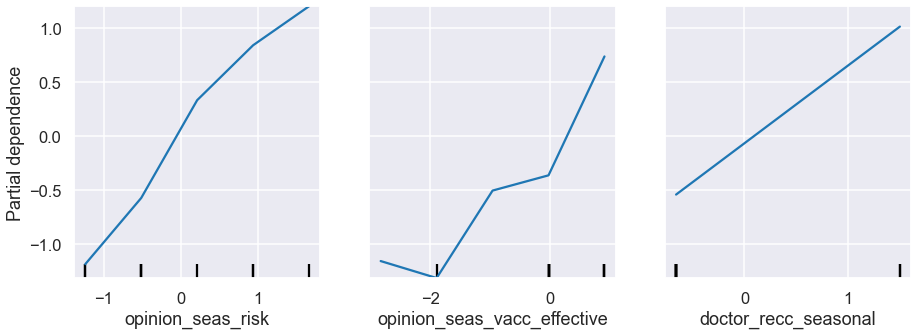

In [64]:
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("talk")
plot_partial_dependence(svm_1_ssnl, X_test_scaled,['opinion_seas_risk','opinion_seas_vacc_effective','doctor_recc_seasonal'])
plt.savefig('data/partial_dependency_chart_ssnl.jpg', dpi=300, bbox_inches='tight')
fig = plt.gcf()
fig.set_size_inches(15,5)

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


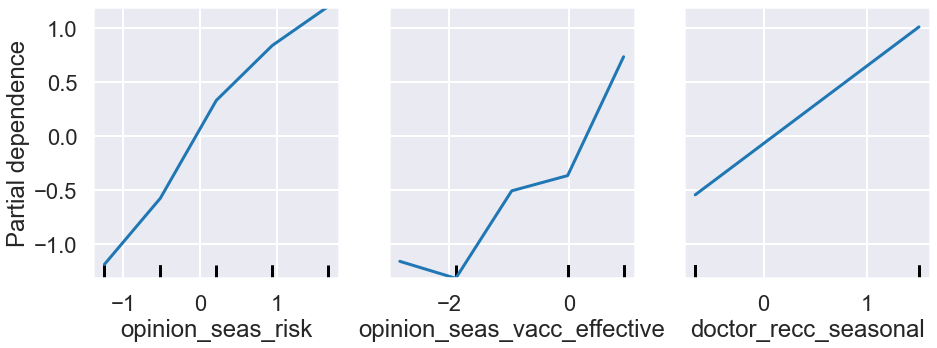

In [65]:
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("poster")
plot_partial_dependence(svm_1_ssnl, X_test_scaled,['opinion_seas_risk','opinion_seas_vacc_effective','doctor_recc_seasonal'])
plt.savefig('data/partial_dependency_chart_ssnl.jpg', dpi=300, bbox_inches='tight')
fig = plt.gcf()
fig.set_size_inches(15,5)

In [67]:
# w = eli5.show_weights(perm, feature_names=X_test_scaled.columns.tolist())
# result = pd.read_html(w.data)[0]
# result